<a href="https://colab.research.google.com/github/maverick98/Coursera/blob/master/machine_learning_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**
Ensuring access to clean drinking water is vital for health, constituting a fundamental human
right and a key element of sound health protection policies. This issue holds significance at the
national, regional, and local levels in terms of both health and development. The objective is to
predict the potability of water based on given features.
The water_potability.csv file contains water quality metrics for 3276 different water bodies.

**Team Members**



1.   GIRIJA SHANKAR SAHOO - 2023AA05235
2.   SOURAJEET SAHOO - 2023AA05029
3.   MANO RANJAN SAHU - 2023AA05738
4.   S SRIDHAR - 2023AB05096







**1. Import Libraries/Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/Assignment-1_Set-8_Dataset.csv /content

Mounted at /content/drive


In [3]:
!pip -qq install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.5 MB/s eta 0:00:00


In [50]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score,GridSearchCV#HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


**2. Data Visualization and Exploration**

a. Print 2 rows for sanity check to identify all the features present in the dataset and if the
target matches with them.
b. Comment on class imbalance with appropriate visualization method.
c. Provide appropriate data visualizations to get an insight about the dataset.
d. Do the correlational analysis on the dataset. Provide a visualization for the same. Will
this correlational analysis have effect on feature selection that you will perform in the
next step? Justify your answer. Answer without justification will not be awarded marks

In [5]:
def read_data():
    df = pd.read_csv("/content/Assignment-1_Set-8_Dataset.csv")
    return df

In [6]:
def describe(df):
    print(df.head())
    print(df.describe())
    print(df.shape)
    print(df.columns)

In [7]:
df = read_data()
describe(df)

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean     

In [8]:
def show_feature_distributions(df):
    df.hist(bins=20, figsize=(10,5), grid=False)
    plt.suptitle("Feature Distribution", fontsize=16)
    plt.show()

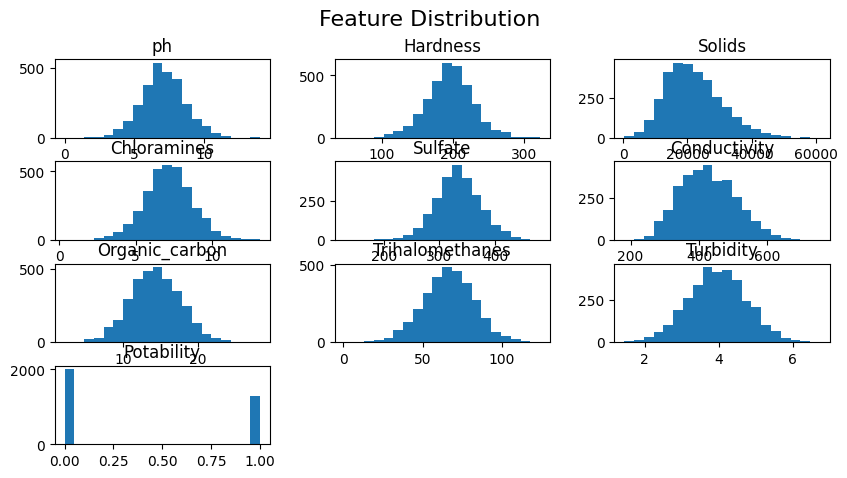

In [9]:
# Feature distribution visualizations
show_feature_distributions(df)

We can see all the features are normally distributed.

In [10]:

# c. Class imbalance visualization
def plot_class_distribution(df):
    sns.countplot(x='Potability', data=df)
    plt.title('Class Distribution')
    plt.xlabel('Potability')
    plt.ylabel('Count')
    plt.show()

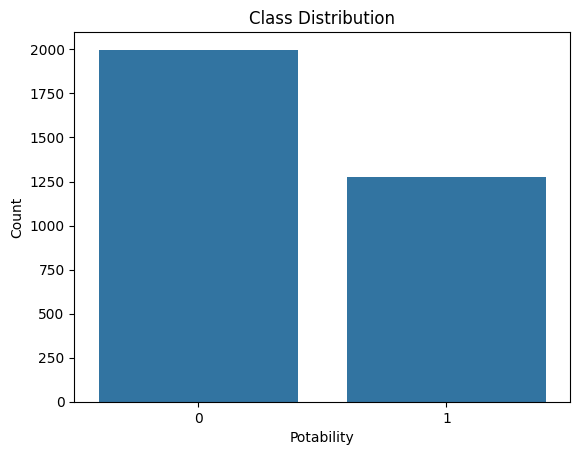

In [11]:
plot_class_distribution(df)

The above plots clearly shows there is class imbalance this dataset.So we will apply techniques like UnderSampling/OverSampling/ SMOTE for better model performance. Since the problem is about potability of water, we do not want False Positives. We are looking for better Precision and Recall. In other words, We will select the model with better F1 score for this problem.

In [12]:
def plot_box_plots(df):
    for col in df.columns:
        plt.figure(figsize=(7,5))
        sns.boxplot(data=df[col],orient='H')
        plt.show


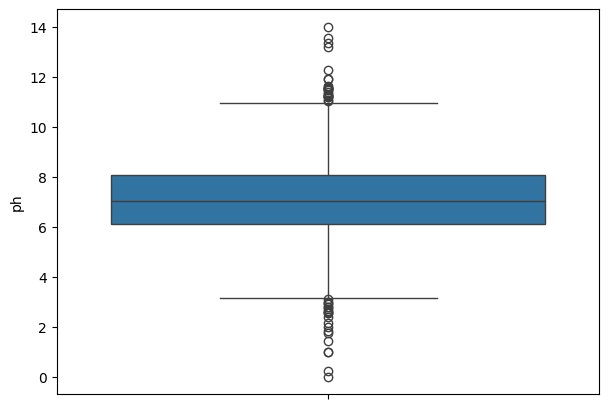

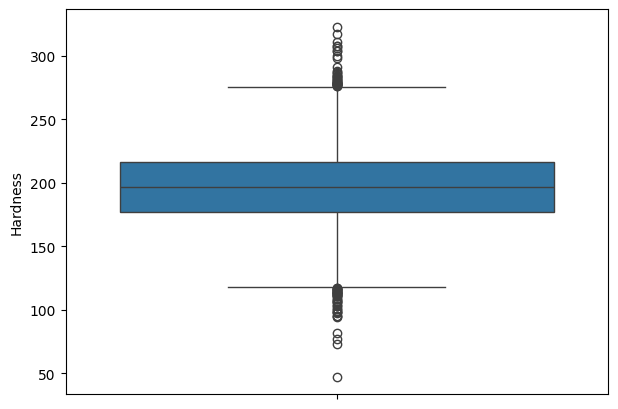

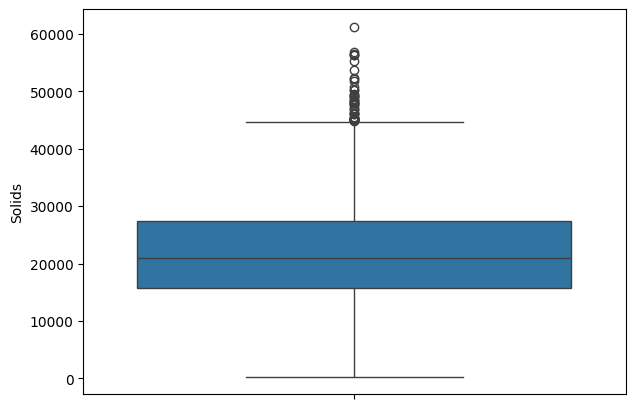

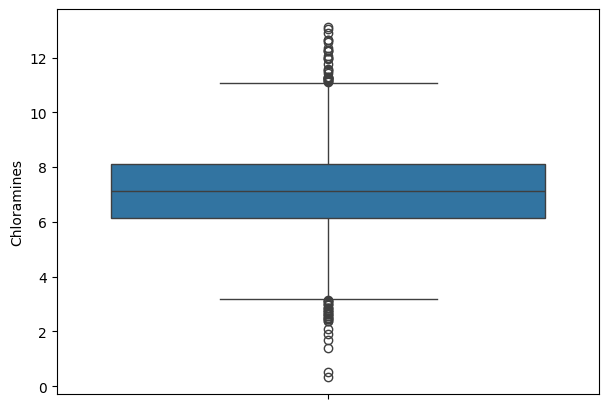

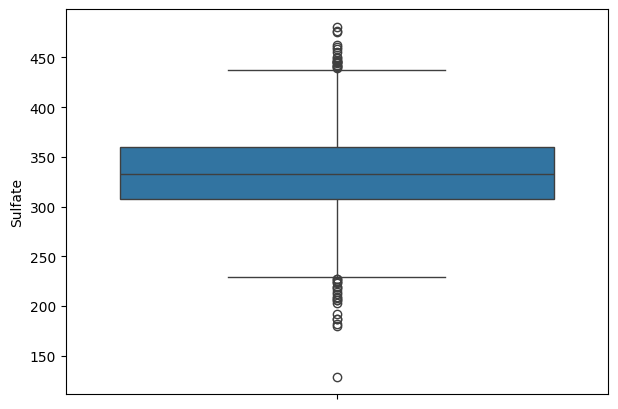

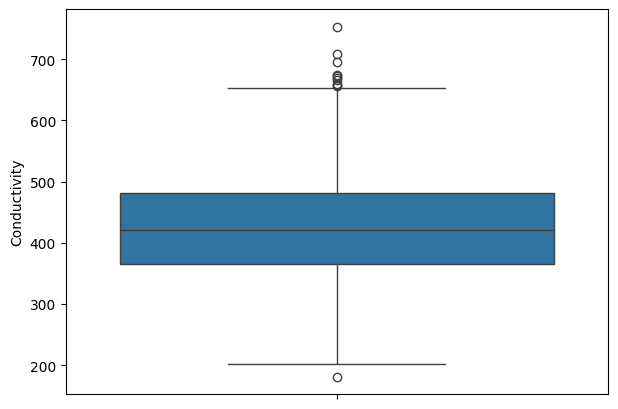

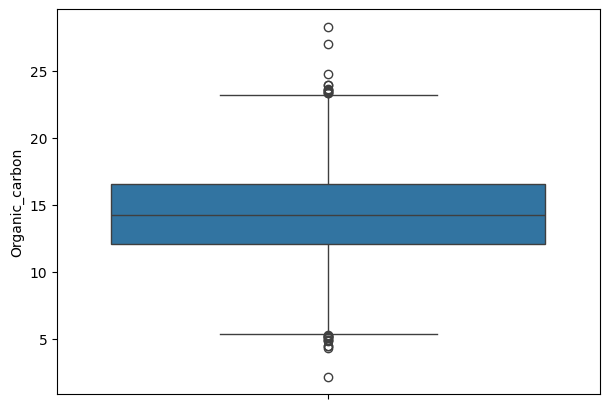

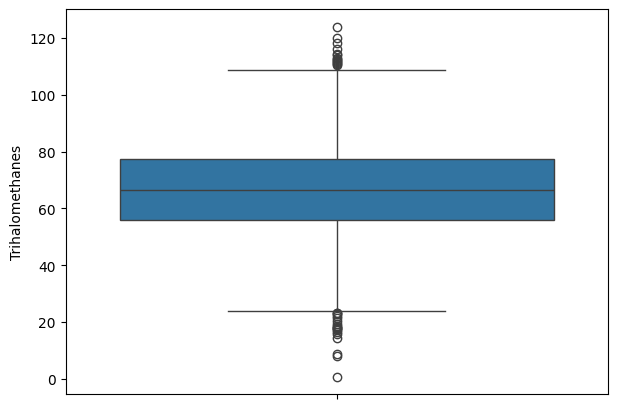

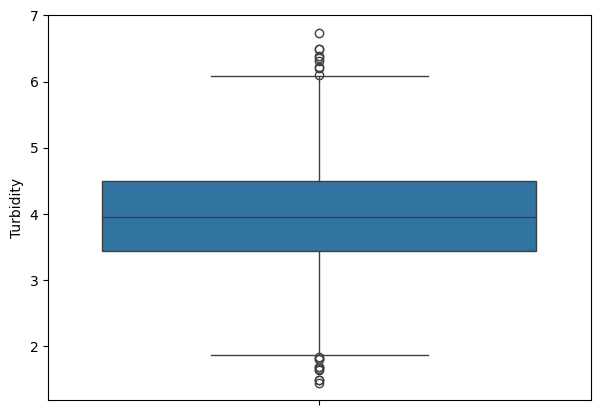

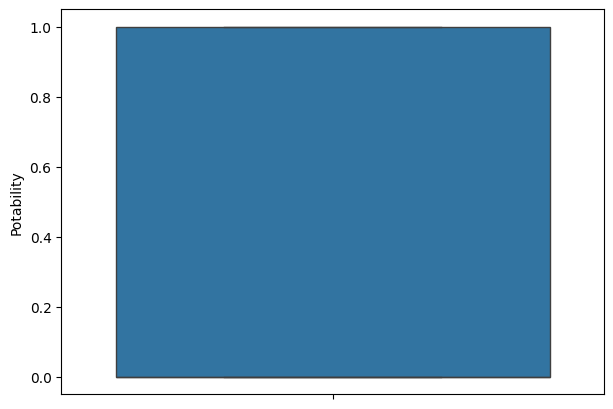

In [13]:
plot_box_plots(df)

For most of the features, we have outliers, So we will treat them prior to feeding to model. Essentially we will remove them

In [14]:
def get_feature_cols(df):
    feature_cols=[]
    for col in df.columns:
        if col != 'Potability':
            feature_cols.append(col)
    print(feature_cols)
    return feature_cols

#
# This removes the outliers
#
#
def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df.describe()[colm].loc["25%"]
    q3 = df.describe()[colm].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df
def treat_outliers(df):
    df_outlier_treated = df.copy()
    feature_cols=get_feature_cols(df)
    for col in feature_cols:
        df_outlier_treated = handle_outliers(df_outlier_treated, col)
    return df_outlier_treated


In [15]:
df_outlier_treated=treat_outliers(df)

['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']


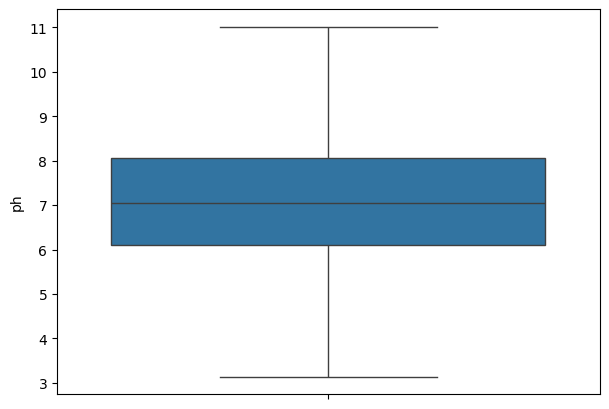

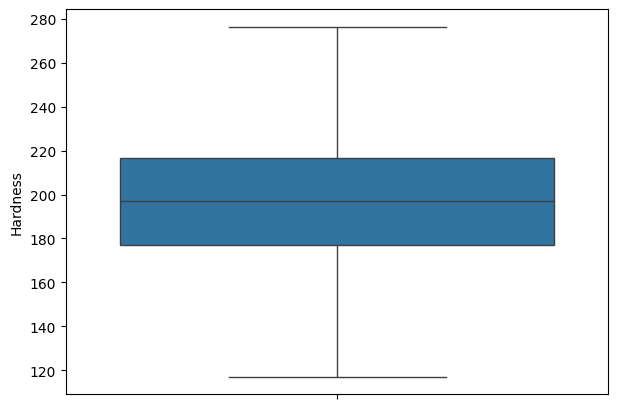

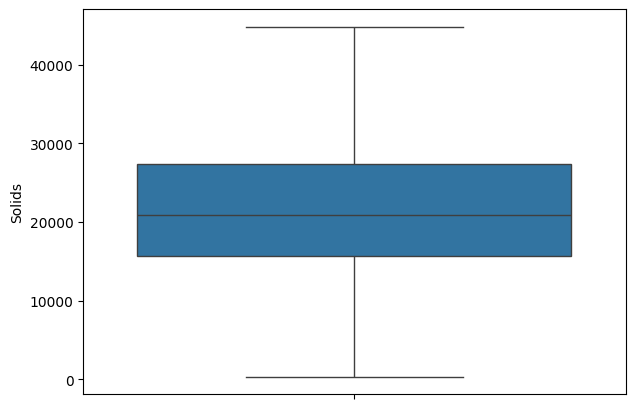

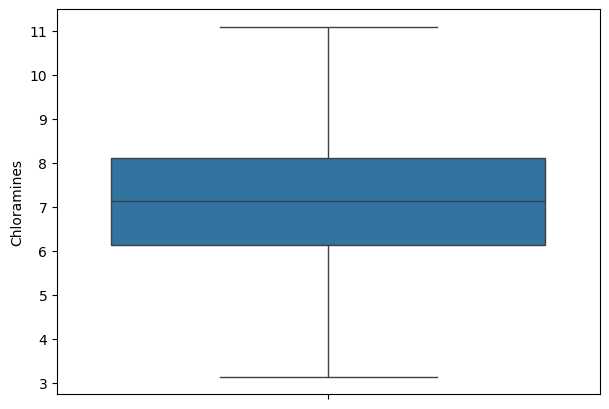

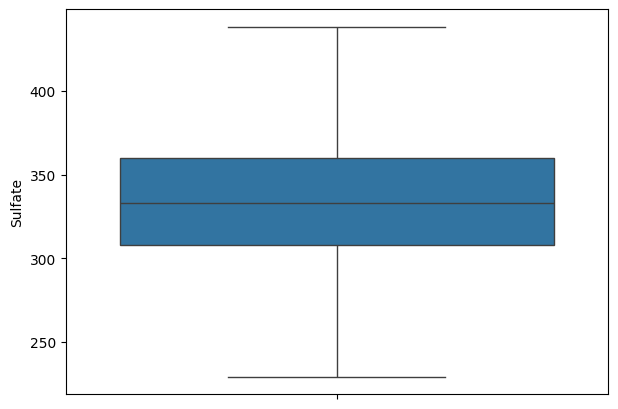

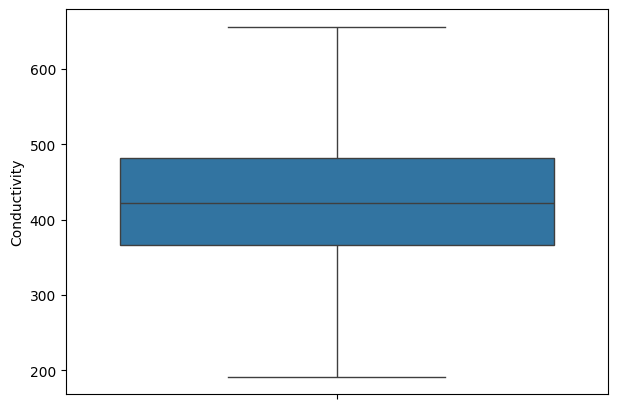

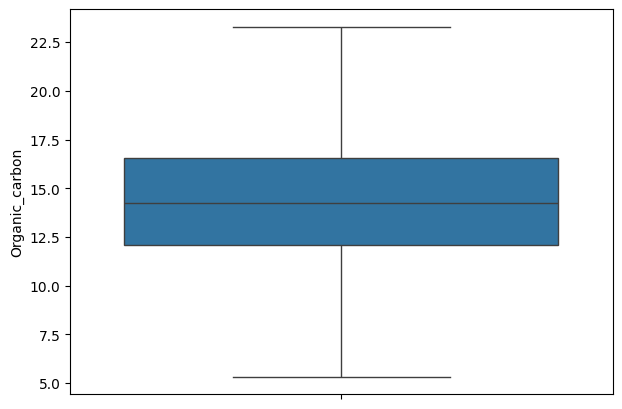

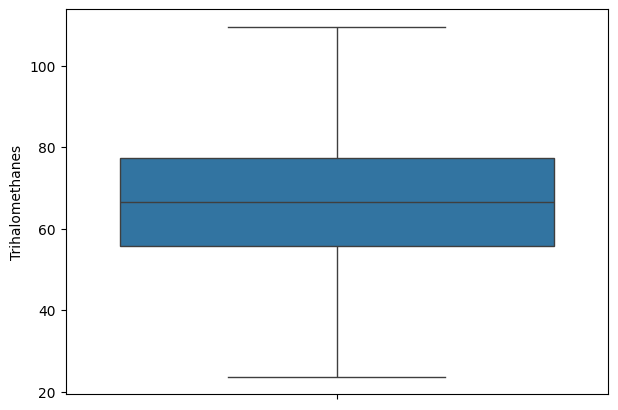

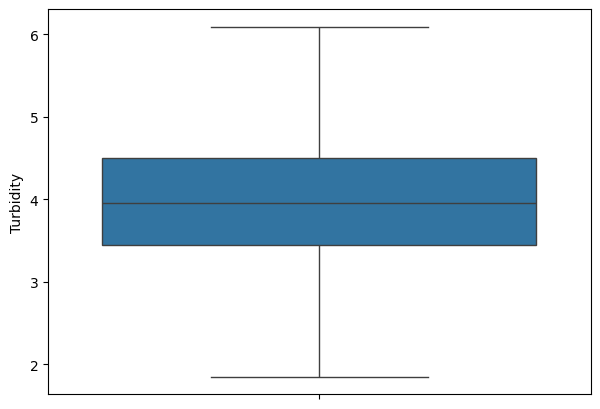

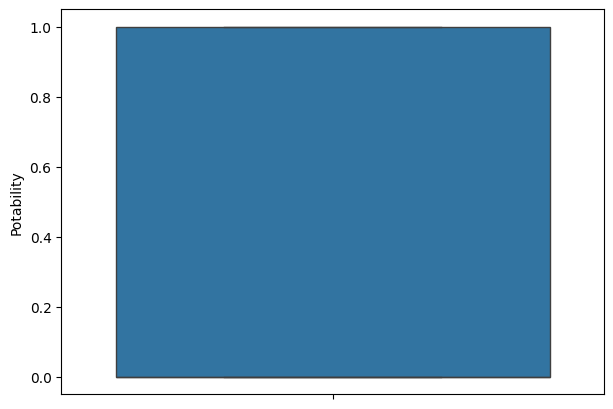

In [16]:
plot_box_plots(df_outlier_treated)

In [17]:
describe(df_outlier_treated)

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean     

In [18]:
def plot_corr(df):
    # d. Correlational analysis and visualization
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

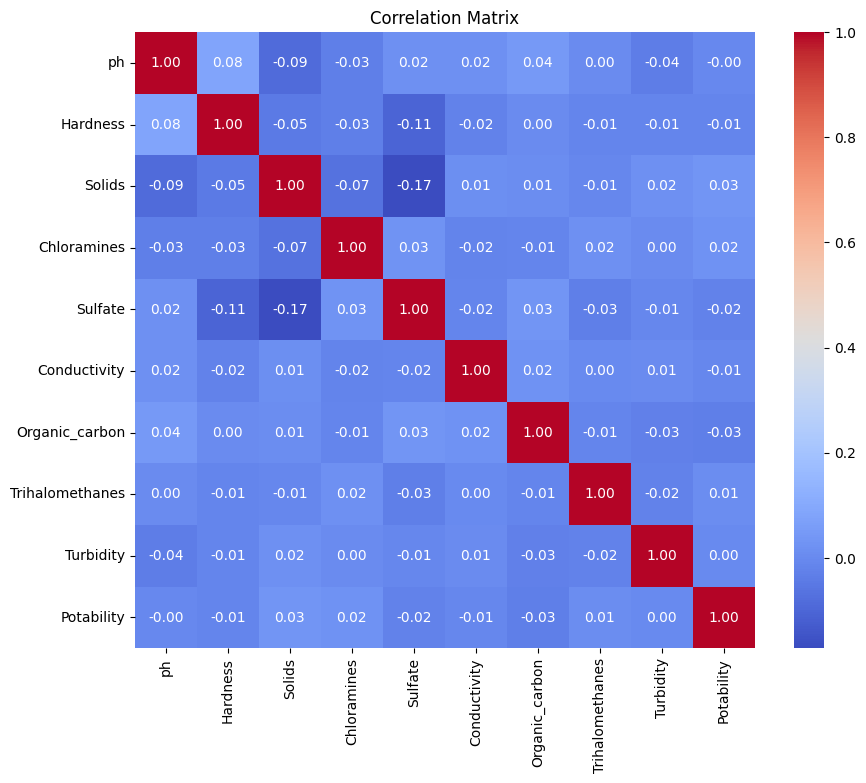

In [19]:
plot_corr(df)

The above heatmap shows how different features are correlated with eachother. As we see above, most of the features are not highly correlated with eachother. 1 indicates high +ve corrrelation while -1 indicates high -ve correlation.

Also the correlation of the features with the target (Potability) do not show correlation.

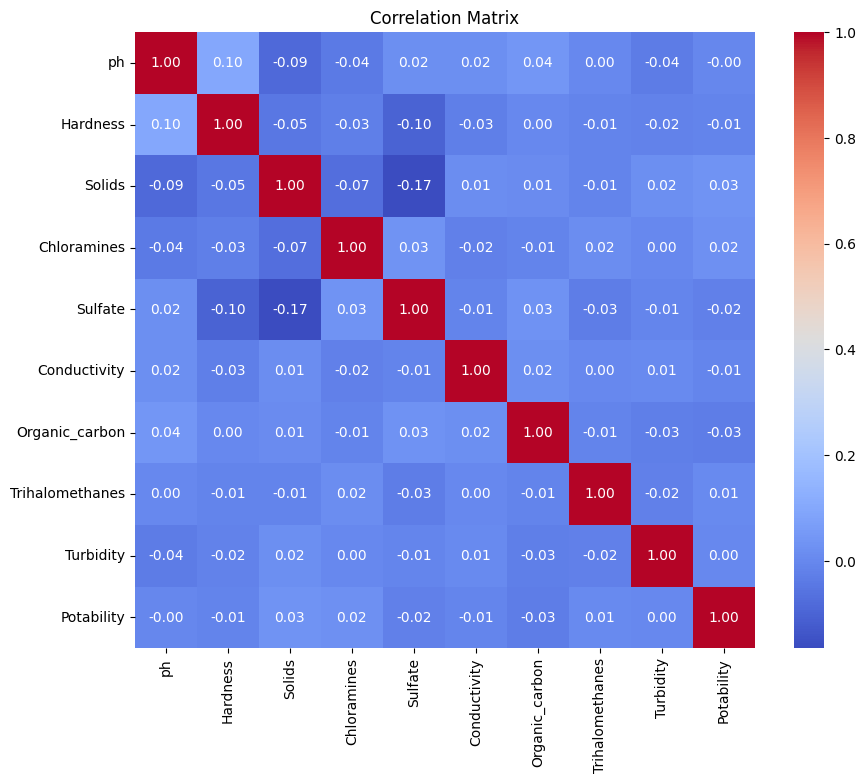

In [20]:
plot_corr(df_outlier_treated)

In [21]:




# Correlation analysis will help in identifying highly correlated features. Highly correlated features can be redundant for the model and may affect model performance. Thus, it may have an effect on feature selection.


In [22]:
# a. Pre-processing steps
# Checking for missing values
def check_null(df):
    print(df.isnull().sum())

In [23]:
check_null(df)
check_null(df_outlier_treated)

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


As we see, certain features like ph,Sulfate, Trihalomethanes have significant amount null values, we will impute them with median values prior to feeding to our model

In [24]:
def impute_data(df):
    # Handling missing values using SimpleImputer
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df_imputed


In [25]:
df_outlier_treated_imputed=impute_data(df_outlier_treated)
check_null(df_outlier_treated_imputed)

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


We now have all our features imputed. There are no null values in the dataset.

In [26]:
describe(df_outlier_treated_imputed)

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.036752  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246  333.073546    592.885359   
2  8.099124  224.236259  19909.541732     9.275884  333.073546    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135         0.0  
1       15.180013        56.329076   4.500656         0.0  
2       16.868637        66.420093   3.055934         0.0  
3       18.436524       100.341674   4.628771         0.0  
4       11.558279        31.997993   4.075075         0.0  
                ph     Hardness        Solids  Chloramines      Sulfate  \
count  3276.000000  3276.000000   3276.000000  3276.000000  3276.000000   
mean     

In [27]:
def extract_X_y(df):
    # b. Feature Engineering
    # Splitting features and target variable
    X = df_outlier_treated_imputed.drop('Potability', axis=1)
    y = df_outlier_treated_imputed['Potability']

    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test
def scale_feature(X_train,X_test):
    # Feature scaling using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled,X_test_scaled


In [28]:
X_train, X_test, y_train, y_test=extract_X_y(df_outlier_treated_imputed)
X_train_scaled,X_test_scaled=scale_feature(X_train, X_test)

In [29]:
def conf_matrix(y_test, y_pred):
    con_mat = confusion_matrix(y_test, y_pred)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values');

In [30]:
def model_prediction(model,model_desc):
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(model_desc)
    conf_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC Score: {roc_auc}")
    print(classification_report(y_test, y_pred))

In [31]:
def build_vanilla_logistic_model( ):
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train_scaled, y_train)
    return logistic_model
def build_balanced_logistic_model():
    logistic_model = LogisticRegression(solver='newton-cg', class_weight='balanced')
    logistic_model.fit(X_train_scaled, y_train )
    return logistic_model
def build_vainlla_decision_tree_model( ):
    decision_tree_model = DecisionTreeClassifier()
    decision_tree_model.fit(X_train_scaled, y_train)
    return decision_tree_model
def build_decision_tree_model( ):
    decision_tree_model = DecisionTreeClassifier(max_depth =16, min_samples_leaf =1, min_samples_split = 2, random_state=42)
    decision_tree_model.fit(X_train_scaled, y_train)
    return decision_tree_model
def build_balanced_decision_tree_model( ):
    decision_tree_model = DecisionTreeClassifier(class_weight='balanced',max_depth =16, min_samples_leaf =1, min_samples_split = 2, random_state=42)
    decision_tree_model.fit(X_train_scaled, y_train)
    return decision_tree_model
def build_knn_model():
    knn_clf = KNN()
    knn_clf.fit(X_train_scaled, y_train)
    return knn_clf
def build_svm_model():
    svm_clf = SVC(probability= True)
    svm_clf.fit(X_train_scaled, y_train)
    return svm_clf
def build_naive_bayes_model():
    gnb_classifier=GaussianNB()
    gnb_classifier.fit(X_train_scaled, y_train)
    return gnb_classifier

def build_random_forest_classifier():
    rf_clf = RandomForestClassifier(n_estimators=300,
                                max_leaf_nodes=16,
                                random_state= 42
                                )
    rf_clf.fit(X_train_scaled, y_train)
    return rf_clf
def build_balanced_bagging_classifier():
    balanced_bagging_classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
    balanced_bagging_classifier.fit(X_train_scaled, y_train)
    return balanced_bagging_classifier
def build_adaboost_model():
    ada_boost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         n_estimators=125,
                         learning_rate = 0.6,
                         random_state=42)

    ada_boost_clf.fit(X_train_scaled, y_train)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    n_scores = cross_val_score(ada_boost_clf, X_train_scaled, y_train, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
    ('Accuracy: %.3f' % (np.mean(n_scores)*100))
    return ada_boost_clf

def build_catboost_model():
    cat_boost_clf = CatBoostClassifier(iterations=5,learning_rate=0.1)
    cat_boost_clf.fit(X_train_scaled, y_train,eval_set = (X_test_scaled, y_test),verbose = False)
    return cat_boost_clf
def build_xgboost_model():
    xg_boost_clf = XGBClassifier(learning_rate=0.1,)
    xg_boost_clf.fit(X_train_scaled, y_train,eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)],verbose = False)
    return xg_boost_clf
def build_libgbm_model():
    libgbm_clf = LGBMClassifier(learning_rate = 0.1)
    libgbm_clf.fit(X_train_scaled, y_train,eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)])
    return libgbm_clf


In [32]:
vanilla_logistic_model=build_vanilla_logistic_model()
logistic_model=build_balanced_logistic_model()
vanilla_decision_tree_model=build_vainlla_decision_tree_model()
decision_tree_model=build_decision_tree_model()
balanced_decision_tree_model=build_balanced_decision_tree_model()
knn_model=build_knn_model()
svm_model=build_svm_model()
naive_bayes_model=build_naive_bayes_model()
random_forest_model=build_random_forest_classifier()
balanced_bagging_classifier=build_balanced_bagging_classifier()
libgbm_model=build_libgbm_model()
cat_boost_model=build_catboost_model()
xg_boost_model=build_xgboost_model()
ada_boost_model=build_adaboost_model()





/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1034, number of negative: 1586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2620, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394656 -> initscore=-0.427780
[LightGBM] [Info] Start training from score -0.427780


In [53]:
rf=RandomForestClassifier()
param_grid=[
                {'n_estimators': [100, 200,],'max_features': [2,4,6,8]},
                {
                    'bootstrap':[False],'n_estimators': [30, 100, 200],'max_features': [2,3,4]
                }
]
#grid_search=HalvingGridSearchCV(rf,param_grid,cv=5,scoring='f1_weighted',return_train_score=True)
grid_search_cv=GridSearchCV(rf,param_grid,cv=5,scoring='f1_weighted',return_train_score=True)
grid_search_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [100, 200]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [30, 100, 200]}],
             return_train_score=True, scoring='f1_weighted')

In [54]:
grid_search_cv.best_estimator_



RandomForestClassifier(max_features=8)

In [ ]:
grid_search_cv.best_estimator_

In [57]:
grid_search_cv.best_params_

{'max_features': 8, 'n_estimators': 100}

In [ ]:
grid_search_cv.best_estimator_.fit(X_train_scaled, y_train)

Random Forest with grid search params Model Performance
Accuracy: 0.6783536585365854
Precision: 0.6122448979591837
Recall: 0.36885245901639346
F1 Score: 0.4603580562659847
ROC AUC Score: 0.6152514722266433
              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77       412
         1.0       0.61      0.37      0.46       244

    accuracy                           0.68       656
   macro avg       0.65      0.62      0.62       656
weighted avg       0.67      0.68      0.66       656



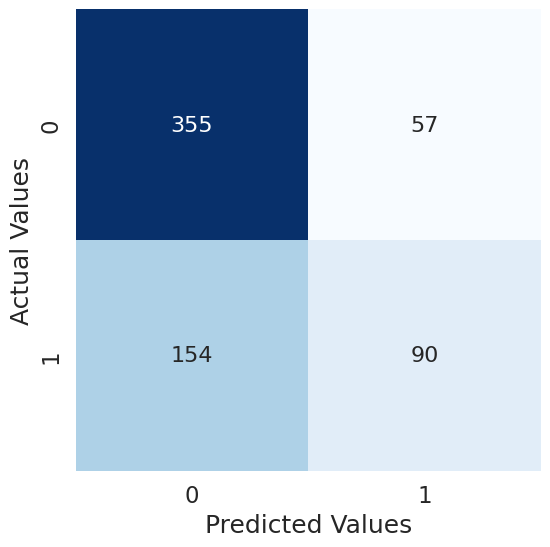

In [58]:
model_prediction(grid_search_cv.best_estimator_,'Random Forest with grid search params Model Performance')

This has performed better than without hyperparameter search using Random Forest. It's F1 score is 0.46 which is much better than the one with without any hyper parameter search of RandomForestClassifier

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

Logistic Model Performance
Accuracy: 0.6280487804878049
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77       412
         1.0       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656



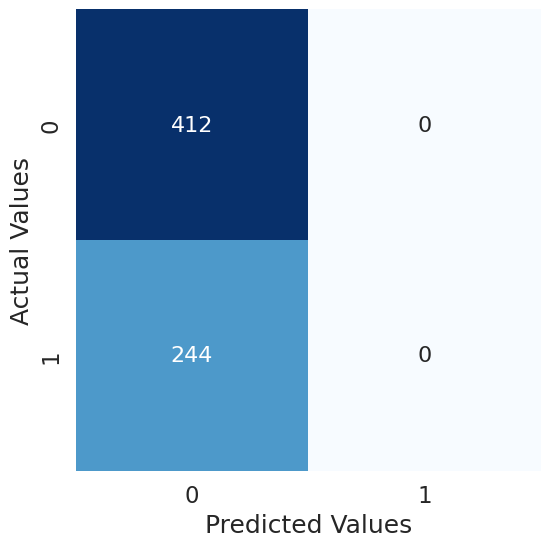

In [33]:
model_prediction(vanilla_logistic_model,'Logistic Model Performance')

Logistic Model with class weights Performance
Accuracy: 0.5076219512195121
Precision: 0.3753943217665615
Recall: 0.48770491803278687
F1 Score: 0.4242424242424242
ROC AUC Score: 0.5035611968804711
              precision    recall  f1-score   support

         0.0       0.63      0.52      0.57       412
         1.0       0.38      0.49      0.42       244

    accuracy                           0.51       656
   macro avg       0.50      0.50      0.50       656
weighted avg       0.54      0.51      0.52       656



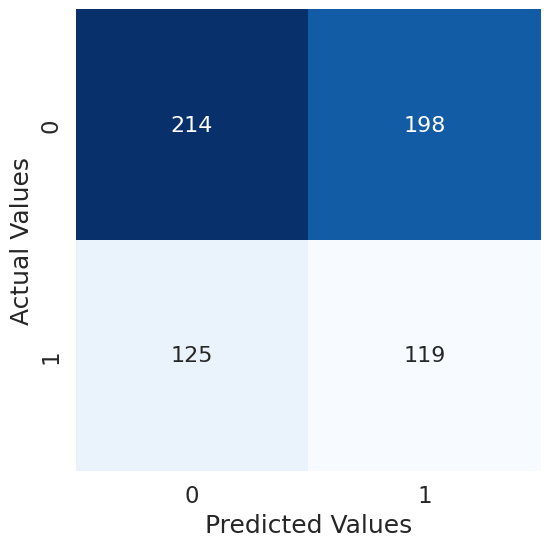

In [34]:
model_prediction(logistic_model,'Logistic Model with class weights Performance')

Vanilla Decision Tree Model performance
Accuracy: 0.5655487804878049
Precision: 0.4259927797833935
Recall: 0.48360655737704916
F1 Score: 0.45297504798464483
ROC AUC Score: 0.5488421136399809
              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64       412
         1.0       0.43      0.48      0.45       244

    accuracy                           0.57       656
   macro avg       0.55      0.55      0.55       656
weighted avg       0.58      0.57      0.57       656



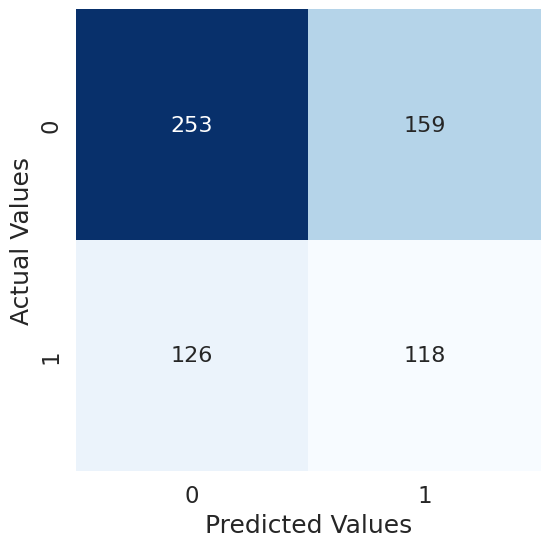

In [35]:
model_prediction(vanilla_decision_tree_model,'Vanilla Decision Tree Model performance')

Decision Tree Model performance
Accuracy: 0.5625
Precision: 0.4234875444839858
Recall: 0.48770491803278687
F1 Score: 0.4533333333333333
ROC AUC Score: 0.5472505172688206
              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64       412
         1.0       0.42      0.49      0.45       244

    accuracy                           0.56       656
   macro avg       0.55      0.55      0.54       656
weighted avg       0.58      0.56      0.57       656



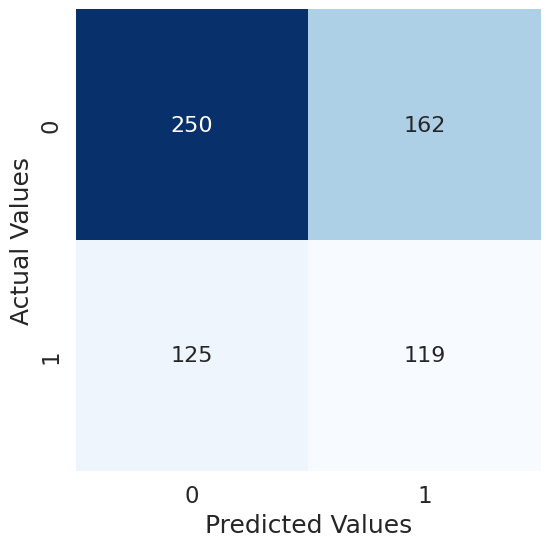

In [36]:
model_prediction(decision_tree_model,'Decision Tree Model performance')

Balanced Decision Tree Model Performance
Accuracy: 0.5914634146341463
Precision: 0.4586206896551724
Recall: 0.5450819672131147
F1 Score: 0.49812734082397
ROC AUC Score: 0.5820070030240331
              precision    recall  f1-score   support

         0.0       0.70      0.62      0.66       412
         1.0       0.46      0.55      0.50       244

    accuracy                           0.59       656
   macro avg       0.58      0.58      0.58       656
weighted avg       0.61      0.59      0.60       656



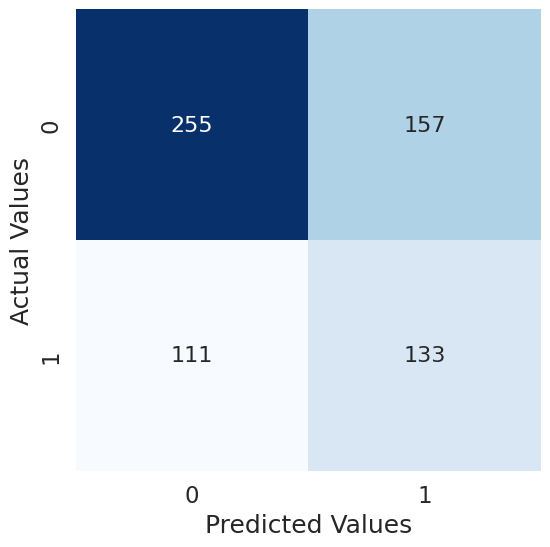

In [37]:
model_prediction(balanced_decision_tree_model,'Balanced Decision Tree Model Performance')

K Nearest Neighbour Model Performance
Accuracy: 0.6219512195121951
Precision: 0.49019607843137253
Recall: 0.4098360655737705
F1 Score: 0.4464285714285714
ROC AUC Score: 0.5787044405538756
              precision    recall  f1-score   support

         0.0       0.68      0.75      0.71       412
         1.0       0.49      0.41      0.45       244

    accuracy                           0.62       656
   macro avg       0.59      0.58      0.58       656
weighted avg       0.61      0.62      0.61       656



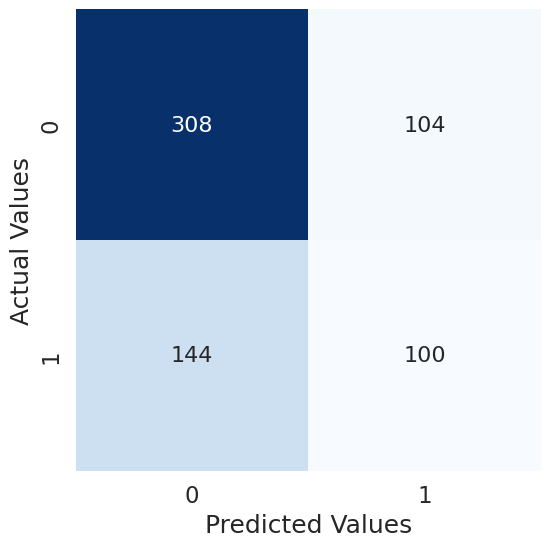

In [38]:
model_prediction(knn_model,'K Nearest Neighbour Model Performance')

Support Vector Machine Model Performance
Accuracy: 0.698170731707317
Precision: 0.7129629629629629
Recall: 0.3155737704918033
F1 Score: 0.43750000000000006
ROC AUC Score: 0.6201655260226008
              precision    recall  f1-score   support

         0.0       0.70      0.92      0.79       412
         1.0       0.71      0.32      0.44       244

    accuracy                           0.70       656
   macro avg       0.70      0.62      0.62       656
weighted avg       0.70      0.70      0.66       656



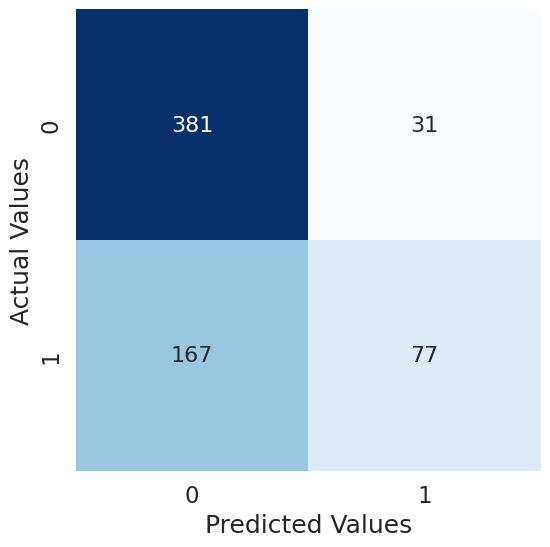

In [39]:
model_prediction(svm_model,'Support Vector Machine Model Performance')

Naive Bayes Model Performance
Accuracy: 0.6295731707317073
Precision: 0.5054945054945055
Recall: 0.1885245901639344
F1 Score: 0.27462686567164174
ROC AUC Score: 0.5396506445965302
              precision    recall  f1-score   support

         0.0       0.65      0.89      0.75       412
         1.0       0.51      0.19      0.27       244

    accuracy                           0.63       656
   macro avg       0.58      0.54      0.51       656
weighted avg       0.60      0.63      0.57       656



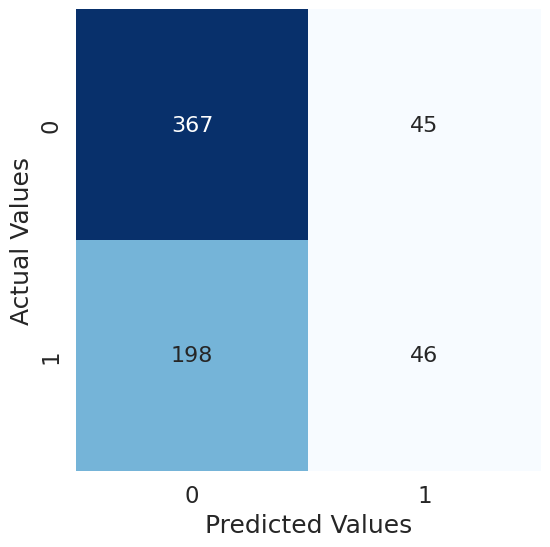

In [40]:
model_prediction(naive_bayes_model,'Naive Bayes Model Performance')

Random Forest Model Performance
Accuracy: 0.6646341463414634
Precision: 0.7307692307692307
Recall: 0.1557377049180328
F1 Score: 0.2567567567567568
ROC AUC Score: 0.5608785611968805
              precision    recall  f1-score   support

         0.0       0.66      0.97      0.78       412
         1.0       0.73      0.16      0.26       244

    accuracy                           0.66       656
   macro avg       0.69      0.56      0.52       656
weighted avg       0.69      0.66      0.59       656



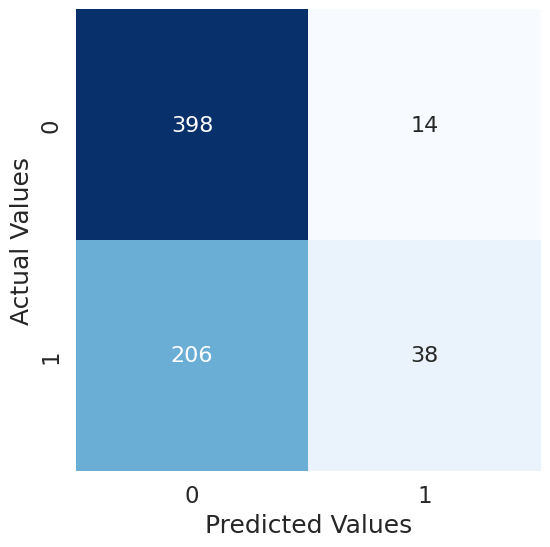

In [41]:
model_prediction(random_forest_model,'Random Forest Model Performance')

Balanced Bagging classifier Model Performance
Accuracy: 0.663109756097561
Precision: 0.5851851851851851
Recall: 0.3237704918032787
F1 Score: 0.41688654353562005
ROC AUC Score: 0.5939240808530957
              precision    recall  f1-score   support

         0.0       0.68      0.86      0.76       412
         1.0       0.59      0.32      0.42       244

    accuracy                           0.66       656
   macro avg       0.63      0.59      0.59       656
weighted avg       0.65      0.66      0.63       656



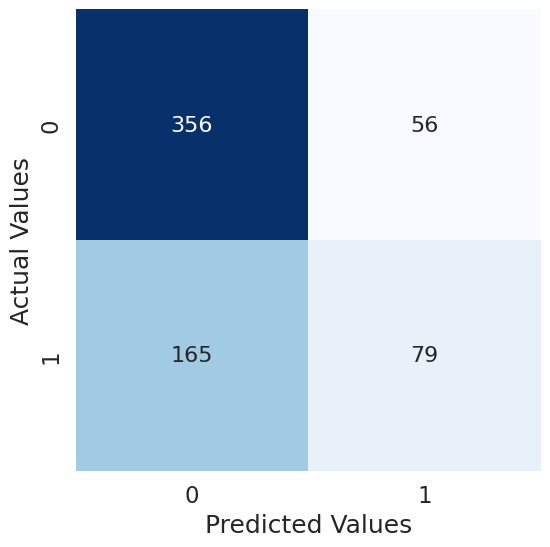

In [42]:
model_prediction(balanced_bagging_classifier,'Balanced Bagging classifier Model Performance')

AdaBoost Model Performance
Accuracy: 0.635670731707317
Precision: 0.5125628140703518
Recall: 0.4180327868852459
F1 Score: 0.46049661399548536
ROC AUC Score: 0.5912979468406813
              precision    recall  f1-score   support

         0.0       0.69      0.76      0.72       412
         1.0       0.51      0.42      0.46       244

    accuracy                           0.64       656
   macro avg       0.60      0.59      0.59       656
weighted avg       0.62      0.64      0.63       656



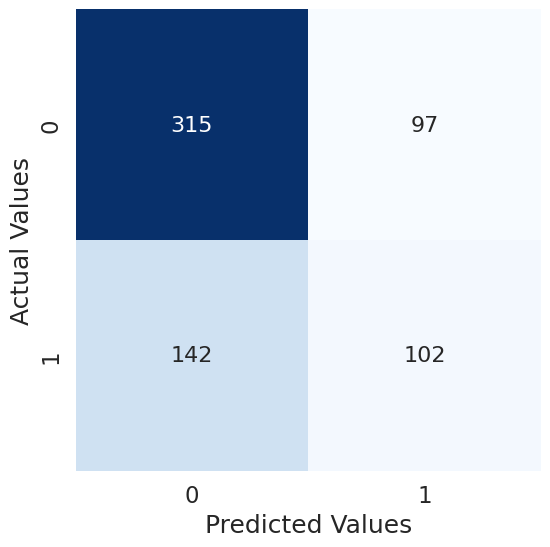

In [43]:
model_prediction(ada_boost_model,'AdaBoost Model Performance')

XGBoost Model Performance
Accuracy: 0.6722560975609756
Precision: 0.5947712418300654
Recall: 0.3729508196721312
F1 Score: 0.4584382871536524
ROC AUC Score: 0.6112326913894637
              precision    recall  f1-score   support

         0.0       0.70      0.85      0.77       412
         1.0       0.59      0.37      0.46       244

    accuracy                           0.67       656
   macro avg       0.65      0.61      0.61       656
weighted avg       0.66      0.67      0.65       656



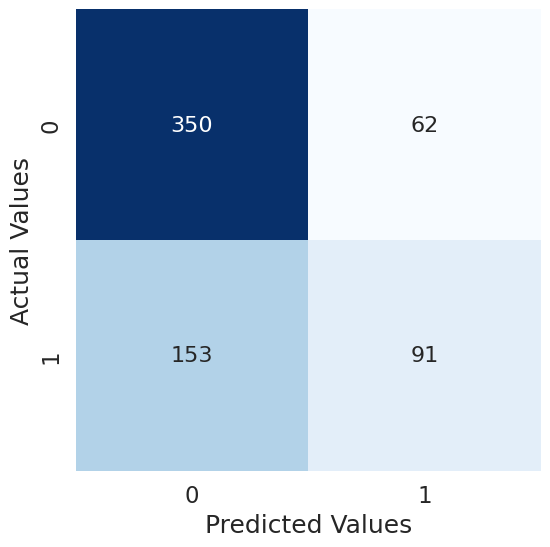

In [44]:
model_prediction(xg_boost_model,'XGBoost Model Performance')

CatBoost Model Performance
Accuracy: 0.649390243902439
Precision: 0.71875
Recall: 0.0942622950819672
F1 Score: 0.16666666666666666
ROC AUC Score: 0.5362088174438963
              precision    recall  f1-score   support

         0.0       0.65      0.98      0.78       412
         1.0       0.72      0.09      0.17       244

    accuracy                           0.65       656
   macro avg       0.68      0.54      0.47       656
weighted avg       0.67      0.65      0.55       656



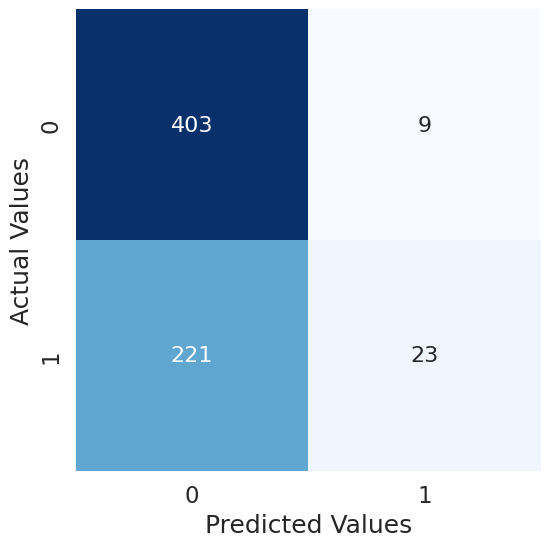

In [45]:
model_prediction(cat_boost_model,'CatBoost Model Performance')

LightGBM Model Performance
Accuracy: 0.6676829268292683
Precision: 0.5722222222222222
Recall: 0.42213114754098363
F1 Score: 0.4858490566037736
ROC AUC Score: 0.6176189718287443
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75       412
         1.0       0.57      0.42      0.49       244

    accuracy                           0.67       656
   macro avg       0.64      0.62      0.62       656
weighted avg       0.65      0.67      0.65       656



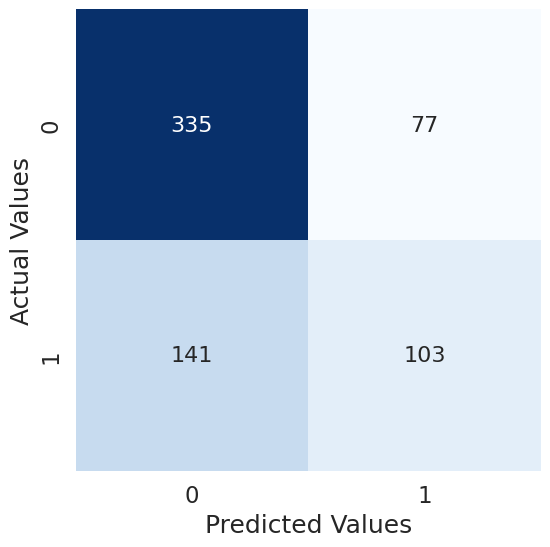

In [46]:
model_prediction(libgbm_model,'LightGBM Model Performance')